Logistic regression:
$$logit = W^Tx$$

Think of words as categories:
- one-hot encoding
- embedding

If $x$ is last word, $y$ is current word, then this is exactly a bigram: $P(y|x) = softmax(W^Tx)$

In general, $X$ is $N\times D$ matrix of input samples, $Y$ is an $N\times K$ matrix of output targets. In our case, we want $D=V$ and $K=V$ (vocabulary size)

In [13]:
 # import
from __future__ import print_function, division
from future.utils import iteritems
from builtins import range, input
import operator

import numpy as np
import random
from datetime import datetime

import os

from nltk.corpus import brown

%matplotlib inline
import matplotlib.pyplot as plt

In [6]:
KEEP_WORDS = set([
  'king', 'man', 'queen', 'woman',
  'italy', 'rome', 'france', 'paris',
  'london', 'britain', 'england',
])


def get_sentences():
    # returns 57340 of the Brown corpus
    # each sentence is represented as a list of individual string tokens
    return brown.sents()


def get_sentences_with_word2idx():
    sentences = get_sentences()
    indexed_sentences = []

    i = 2
    word2idx = {'START': 0, 'END': 1}
    for sentence in sentences:
        indexed_sentence = []
        for token in sentence:
            token = token.lower()
            if token not in word2idx:
                word2idx[token] = i
                i += 1
            indexed_sentence.append(word2idx[token])
        indexed_sentences.append(indexed_sentence)

    print("Vocab size:", i)
    return indexed_sentences, word2idx


def get_sentences_with_word2idx_limit_vocab(n_vocab=2000, keep_words=KEEP_WORDS):
    sentences = get_sentences()
    indexed_sentences = []

    i = 2
    word2idx = {'START': 0, 'END': 1}
    idx2word = ['START', 'END']

    word_idx_count = {
        0: float('inf'),
        1: float('inf'),
    }

    for sentence in sentences:
        indexed_sentence = []
        for token in sentence:
            token = token.lower()
            if token not in word2idx:
                idx2word.append(token)
                word2idx[token] = i
                i += 1

            # keep track of counts for later sorting
            idx = word2idx[token]
            word_idx_count[idx] = word_idx_count.get(idx, 0) + 1

            indexed_sentence.append(idx)
        indexed_sentences.append(indexed_sentence)

    # restrict vocab size

    # set all the words I want to keep to infinity
    # so that they are included when I pick the most
    # common words
    for word in keep_words:
        word_idx_count[word2idx[word]] = float('inf')

    sorted_word_idx_count = sorted(word_idx_count.items(), key=operator.itemgetter(1), reverse=True)
    word2idx_small = {}
    new_idx = 0
    idx_new_idx_map = {}
    for idx, count in sorted_word_idx_count[:n_vocab]:
        word = idx2word[idx]
        print(word, count)
        word2idx_small[word] = new_idx
        idx_new_idx_map[idx] = new_idx
        new_idx += 1
    # let 'unknown' be the last token
    word2idx_small['UNKNOWN'] = new_idx 
    unknown = new_idx

    assert('START' in word2idx_small)
    assert('END' in word2idx_small)
    for word in keep_words:
        assert(word in word2idx_small)

    # map old idx to new idx
    sentences_small = []
    for sentence in indexed_sentences:
        if len(sentence) > 1:
            new_sentence = [idx_new_idx_map[idx] if idx in idx_new_idx_map else unknown for idx in sentence]
            sentences_small.append(new_sentence)

    return sentences_small, word2idx_small

In [4]:
# function for bigram probs
def get_bigram_probs(sentences, V, start_idx, end_idx, smoothing=1):
    # structure ofbigram prob matrix:
    #   (last_word_idx, current_word_idx) -> probabiliry
    # we will use add-1 smoothing
    
    bigram_probs = np.ones((V,V)) * smoothing
    for sentence in sentences:
        for i in range(len(sentence)):
            if i == 0:
                bigram_probs[start_idx, sentence[i]] += 1
            else:
                bigram_probs[sentence[i-1], sentence[i]] += 1
            
            if i == len(sentence) -1:
                bigram_probs[sentence[i], end_idx] += 1
        
    # normalize it
    bigram_probs /= bigram_probs.sum(axis=1, keepdims=True)
    return bigram_probs

In [7]:
sentences, word2idx = get_sentences_with_word2idx_limit_vocab(2000)

START inf
END inf
man inf
paris inf
britain inf
england inf
king inf
woman inf
rome inf
london inf
queen inf
italy inf
france inf
the 69971
, 58334
. 49346
of 36412
and 28853
to 26158
a 23195
in 21337
that 10594
is 10109
was 9815
he 9548
for 9489
`` 8837
'' 8789
it 8760
with 7289
as 7253
his 6996
on 6741
be 6377
; 5566
at 5372
by 5306
i 5164
this 5145
had 5133
? 4693
not 4610
are 4394
but 4381
from 4370
or 4206
have 3942
an 3740
they 3620
which 3561
-- 3432
one 3292
you 3286
were 3284
her 3036
all 3001
she 2860
there 2728
would 2714
their 2669
we 2652
him 2619
been 2472
) 2466
has 2437
( 2435
when 2331
who 2252
will 2245
more 2215
if 2198
no 2139
out 2097
so 1985
said 1961
what 1908
up 1890
its 1858
about 1815
: 1795
into 1791
than 1790
them 1788
can 1772
only 1748
other 1702
new 1635
some 1618
could 1601
time 1598
! 1596
these 1573
two 1412
may 1402
then 1380
do 1363
first 1361
any 1344
my 1318
now 1314
such 1303
like 1292
our 1252
over 1236
me 1181
even 1170
most 1159
made 1125
also 

pool 111
hospital 110
corps 110
wish 110
lack 110
completely 110
heavy 110
waiting 110
speak 110
ball 110
standard 110
extent 110
visit 109
democratic 109
firm 109
income 109
ahead 109
deep 109
there's 109
language 109
principle 109
none 108
price 108
designed 108
indicated 108
analysis 108
distance 108
expect 108
established 108
products 108
effects 108
growing 108
importance 108
continue 107
serve 107
determine 107
cities 107
elements 107
negro 107
leaders 107
division 107
pretty 107
easily 107
existence 107
attitude 107
stress 107
8 106
afternoon 106
limited 106
hardly 106
agreement 106
factors 106
scene 106
remained 106
closed 106
write 106
applied 106
health 105
married 105
suggested 105
attack 105
rhode 105
interested 105
station 105
professional 105
won't 105
drive 105
season 105
reach 105
b 105
despite 104
current 104
spent 104
eight 104
covered 104
role 104
played 104
i'd 104
becomes 104
date 103
council 103
race 103
unit 103
commission 103
original 103
mouth 103
reasons 103
s

apparent 57
bay 57
truck 57
majority 57
afraid 57
artist 57
goods 57
birds 57
appearance 57
baseball 57
spot 57
flowers 57
lewis 57
notes 57
enjoyed 57
entrance 57
uncle 57
alive 57
beneath 57
combination 57
truly 57
congo 57
becoming 57
requires 57
sample 57
bear 57
dictionary 57
shook 57
granted 56
l. 56
confidence 56


In [9]:
V = len(word2idx)
print("Vocab size:", V)

start_idx = word2idx['START']
end_idx = word2idx['END']

Vocab size: 2001


In [10]:
# a matrix where:
# row = last word
# col = current word
# value at [row, col] = p(current word | last word)
bigram_probs = get_bigram_probs(sentences, V, start_idx, end_idx, smoothing=0.1)

epoch: 0 sentence: 0/57013 loss: 7.606926760752405
epoch: 0 sentence: 10/57013 loss: 7.422680544639513
epoch: 0 sentence: 20/57013 loss: 7.235052410709704
epoch: 0 sentence: 30/57013 loss: 7.205613759990006
epoch: 0 sentence: 40/57013 loss: 6.934902152297568
epoch: 0 sentence: 50/57013 loss: 7.259992022418961
epoch: 0 sentence: 60/57013 loss: 6.1776716842674455
epoch: 0 sentence: 70/57013 loss: 7.111505282683746
epoch: 0 sentence: 80/57013 loss: 7.2163499366420165
epoch: 0 sentence: 90/57013 loss: 5.8141048877989965
epoch: 0 sentence: 100/57013 loss: 6.691924700821679
epoch: 0 sentence: 110/57013 loss: 6.939652060501376
epoch: 0 sentence: 120/57013 loss: 6.3387897366259836
epoch: 0 sentence: 130/57013 loss: 6.453465552802356
epoch: 0 sentence: 140/57013 loss: 6.738234102991242
epoch: 0 sentence: 150/57013 loss: 7.15771752869251
epoch: 0 sentence: 160/57013 loss: 7.0471039698953035
epoch: 0 sentence: 170/57013 loss: 5.862890600036917
epoch: 0 sentence: 180/57013 loss: 5.4445433814056985

epoch: 0 sentence: 1540/57013 loss: 6.179464354483177
epoch: 0 sentence: 1550/57013 loss: 6.965126597507536
epoch: 0 sentence: 1560/57013 loss: 5.511435115793873
epoch: 0 sentence: 1570/57013 loss: 6.768048564701299
epoch: 0 sentence: 1580/57013 loss: 5.864976645184942
epoch: 0 sentence: 1590/57013 loss: 5.802745495603118
epoch: 0 sentence: 1600/57013 loss: 4.436755338746099
epoch: 0 sentence: 1610/57013 loss: 6.610808522161864
epoch: 0 sentence: 1620/57013 loss: 6.3738422578137115
epoch: 0 sentence: 1630/57013 loss: 6.322045889358852
epoch: 0 sentence: 1640/57013 loss: 5.9302490072800405
epoch: 0 sentence: 1650/57013 loss: 5.733371145833737
epoch: 0 sentence: 1660/57013 loss: 4.016318712447492
epoch: 0 sentence: 1670/57013 loss: 6.809435646183165
epoch: 0 sentence: 1680/57013 loss: 5.113551487200319
epoch: 0 sentence: 1690/57013 loss: 6.188698047895097
epoch: 0 sentence: 1700/57013 loss: 5.802382473695196
epoch: 0 sentence: 1710/57013 loss: 6.354213213855605
epoch: 0 sentence: 1720/57

epoch: 0 sentence: 3060/57013 loss: 3.5011599876554795
epoch: 0 sentence: 3070/57013 loss: 4.491188969935848
epoch: 0 sentence: 3080/57013 loss: 6.241110141882665
epoch: 0 sentence: 3090/57013 loss: 5.04653939777009
epoch: 0 sentence: 3100/57013 loss: 5.70652542231323
epoch: 0 sentence: 3110/57013 loss: 5.833797404125534
epoch: 0 sentence: 3120/57013 loss: 3.9497116600048456
epoch: 0 sentence: 3130/57013 loss: 5.712840759882709
epoch: 0 sentence: 3140/57013 loss: 5.684130318214196
epoch: 0 sentence: 3150/57013 loss: 4.3548256555410845
epoch: 0 sentence: 3160/57013 loss: 4.213744744389757
epoch: 0 sentence: 3170/57013 loss: 6.682231197624517
epoch: 0 sentence: 3180/57013 loss: 2.7703182034710916
epoch: 0 sentence: 3190/57013 loss: 5.8574116228768816
epoch: 0 sentence: 3200/57013 loss: 5.654302667660493
epoch: 0 sentence: 3210/57013 loss: 4.378509234935308
epoch: 0 sentence: 3220/57013 loss: 5.535316542847641
epoch: 0 sentence: 3230/57013 loss: 4.085937351506843
epoch: 0 sentence: 3240/5

epoch: 0 sentence: 4580/57013 loss: 5.809351332732919
epoch: 0 sentence: 4590/57013 loss: 5.502623991860542
epoch: 0 sentence: 4600/57013 loss: 6.448916137400789
epoch: 0 sentence: 4610/57013 loss: 5.789517523845437
epoch: 0 sentence: 4620/57013 loss: 4.330720192291564
epoch: 0 sentence: 4630/57013 loss: 5.876012371917594
epoch: 0 sentence: 4640/57013 loss: 5.2648693744731485
epoch: 0 sentence: 4650/57013 loss: 6.0064008833426055
epoch: 0 sentence: 4660/57013 loss: 6.351219384737892
epoch: 0 sentence: 4670/57013 loss: 4.82255861443784
epoch: 0 sentence: 4680/57013 loss: 5.359664242515453
epoch: 0 sentence: 4690/57013 loss: 5.94257388755195
epoch: 0 sentence: 4700/57013 loss: 5.191245478647124
epoch: 0 sentence: 4710/57013 loss: 3.8750488711074413
epoch: 0 sentence: 4720/57013 loss: 5.3826617365852245
epoch: 0 sentence: 4730/57013 loss: 6.126121100162893
epoch: 0 sentence: 4740/57013 loss: 5.632879832694341
epoch: 0 sentence: 4750/57013 loss: 3.575124253987871
epoch: 0 sentence: 4760/57

epoch: 0 sentence: 6100/57013 loss: 5.798240459367943
epoch: 0 sentence: 6110/57013 loss: 6.228922613185134
epoch: 0 sentence: 6120/57013 loss: 5.257390816093125
epoch: 0 sentence: 6130/57013 loss: 4.341415846664669
epoch: 0 sentence: 6140/57013 loss: 3.901868952655907
epoch: 0 sentence: 6150/57013 loss: 6.190097212137823
epoch: 0 sentence: 6160/57013 loss: 5.318934511657673
epoch: 0 sentence: 6170/57013 loss: 6.514237754478235
epoch: 0 sentence: 6180/57013 loss: 4.665370223227031
epoch: 0 sentence: 6190/57013 loss: 4.245620888290614
epoch: 0 sentence: 6200/57013 loss: 5.4114789417079425
epoch: 0 sentence: 6210/57013 loss: 5.005466234442384
epoch: 0 sentence: 6220/57013 loss: 6.052590616493673
epoch: 0 sentence: 6230/57013 loss: 4.917080080415086
epoch: 0 sentence: 6240/57013 loss: 4.742263989470787
epoch: 0 sentence: 6250/57013 loss: 5.243153693745071
epoch: 0 sentence: 6260/57013 loss: 5.532836183328206
epoch: 0 sentence: 6270/57013 loss: 5.939592649200743
epoch: 0 sentence: 6280/570

epoch: 0 sentence: 7620/57013 loss: 5.4586028968874505
epoch: 0 sentence: 7630/57013 loss: 5.7911399334117455
epoch: 0 sentence: 7640/57013 loss: 5.549261466128149
epoch: 0 sentence: 7650/57013 loss: 5.238095948468071
epoch: 0 sentence: 7660/57013 loss: 3.9032500967096375
epoch: 0 sentence: 7670/57013 loss: 4.620209592623941
epoch: 0 sentence: 7680/57013 loss: 5.311319321958698
epoch: 0 sentence: 7690/57013 loss: 5.291477713126414
epoch: 0 sentence: 7700/57013 loss: 3.4338292791596117
epoch: 0 sentence: 7710/57013 loss: 5.389753263983539
epoch: 0 sentence: 7720/57013 loss: 4.758988466329912
epoch: 0 sentence: 7730/57013 loss: 5.118280331061797
epoch: 0 sentence: 7740/57013 loss: 4.670811125863244
epoch: 0 sentence: 7750/57013 loss: 5.570001470319459
epoch: 0 sentence: 7760/57013 loss: 5.599382906238035
epoch: 0 sentence: 7770/57013 loss: 4.611452463653297
epoch: 0 sentence: 7780/57013 loss: 4.716073147941865
epoch: 0 sentence: 7790/57013 loss: 5.067085474443755
epoch: 0 sentence: 7800/

epoch: 0 sentence: 9140/57013 loss: 5.47016180127336
epoch: 0 sentence: 9150/57013 loss: 5.497014807514101
epoch: 0 sentence: 9160/57013 loss: 5.993151975822476
epoch: 0 sentence: 9170/57013 loss: 3.940062575744087
epoch: 0 sentence: 9180/57013 loss: 4.20606625024333
epoch: 0 sentence: 9190/57013 loss: 5.193501137686459
epoch: 0 sentence: 9200/57013 loss: 5.335641115696464
epoch: 0 sentence: 9210/57013 loss: 4.970870763976136
epoch: 0 sentence: 9220/57013 loss: 4.1956895502501785
epoch: 0 sentence: 9230/57013 loss: 4.758121122719196
epoch: 0 sentence: 9240/57013 loss: 5.82013297052125
epoch: 0 sentence: 9250/57013 loss: 3.9044702720034654
epoch: 0 sentence: 9260/57013 loss: 4.556070361746464
epoch: 0 sentence: 9270/57013 loss: 5.230765930550912
epoch: 0 sentence: 9280/57013 loss: 5.6206122716115186
epoch: 0 sentence: 9290/57013 loss: 5.548201379355344
epoch: 0 sentence: 9300/57013 loss: 5.507768330181923
epoch: 0 sentence: 9310/57013 loss: 6.490536805910429
epoch: 0 sentence: 9320/5701

epoch: 0 sentence: 10650/57013 loss: 5.409814298781985
epoch: 0 sentence: 10660/57013 loss: 4.979641742214856
epoch: 0 sentence: 10670/57013 loss: 6.344661034267578
epoch: 0 sentence: 10680/57013 loss: 4.902906280335215
epoch: 0 sentence: 10690/57013 loss: 4.636231926290128
epoch: 0 sentence: 10700/57013 loss: 5.387301865123869
epoch: 0 sentence: 10710/57013 loss: 4.198025869141494
epoch: 0 sentence: 10720/57013 loss: 5.015880374219384
epoch: 0 sentence: 10730/57013 loss: 3.813264227686402
epoch: 0 sentence: 10740/57013 loss: 3.9882871620736053
epoch: 0 sentence: 10750/57013 loss: 4.163597513197837
epoch: 0 sentence: 10760/57013 loss: 4.039917011703954
epoch: 0 sentence: 10770/57013 loss: 5.85162994031484
epoch: 0 sentence: 10780/57013 loss: 5.730999302765387
epoch: 0 sentence: 10790/57013 loss: 4.371919605308162
epoch: 0 sentence: 10800/57013 loss: 5.41832753573936
epoch: 0 sentence: 10810/57013 loss: 5.023540200598132
epoch: 0 sentence: 10820/57013 loss: 5.902267484878273
epoch: 0 se

epoch: 0 sentence: 12140/57013 loss: 5.436390510065287
epoch: 0 sentence: 12150/57013 loss: 4.458782531103076
epoch: 0 sentence: 12160/57013 loss: 4.993653661534463
epoch: 0 sentence: 12170/57013 loss: 2.146051360059673
epoch: 0 sentence: 12180/57013 loss: 6.542053965797112
epoch: 0 sentence: 12190/57013 loss: 6.188299168952696
epoch: 0 sentence: 12200/57013 loss: 5.075114213489427
epoch: 0 sentence: 12210/57013 loss: 4.308887945311814
epoch: 0 sentence: 12220/57013 loss: 3.875324942198721
epoch: 0 sentence: 12230/57013 loss: 4.851242468520506
epoch: 0 sentence: 12240/57013 loss: 4.5616593090466875
epoch: 0 sentence: 12250/57013 loss: 5.9006972380606975
epoch: 0 sentence: 12260/57013 loss: 4.337085089830215
epoch: 0 sentence: 12270/57013 loss: 4.369641162695293
epoch: 0 sentence: 12280/57013 loss: 3.1244293255252895
epoch: 0 sentence: 12290/57013 loss: 4.9201502321912765
epoch: 0 sentence: 12300/57013 loss: 3.997497884619463
epoch: 0 sentence: 12310/57013 loss: 4.076015051049604
epoch:

epoch: 0 sentence: 13630/57013 loss: 5.951419783713289
epoch: 0 sentence: 13640/57013 loss: 4.361904919747223
epoch: 0 sentence: 13650/57013 loss: 4.598244467027622
epoch: 0 sentence: 13660/57013 loss: 5.14457620126189
epoch: 0 sentence: 13670/57013 loss: 6.3544690314258725
epoch: 0 sentence: 13680/57013 loss: 4.886389064188024
epoch: 0 sentence: 13690/57013 loss: 5.535163517824022
epoch: 0 sentence: 13700/57013 loss: 3.7166575508360467
epoch: 0 sentence: 13710/57013 loss: 5.33704188122584
epoch: 0 sentence: 13720/57013 loss: 4.3544739529216585
epoch: 0 sentence: 13730/57013 loss: 3.9853301408661443
epoch: 0 sentence: 13740/57013 loss: 4.893449811734355
epoch: 0 sentence: 13750/57013 loss: 5.4931802796087155
epoch: 0 sentence: 13760/57013 loss: 5.598667955498167
epoch: 0 sentence: 13770/57013 loss: 6.147894426271672
epoch: 0 sentence: 13780/57013 loss: 4.663736099250764
epoch: 0 sentence: 13790/57013 loss: 5.549948157164901
epoch: 0 sentence: 13800/57013 loss: 5.773478306990366
epoch: 

epoch: 0 sentence: 15120/57013 loss: 5.744335697073627
epoch: 0 sentence: 15130/57013 loss: 5.349045461435669
epoch: 0 sentence: 15140/57013 loss: 6.068231954478332
epoch: 0 sentence: 15150/57013 loss: 5.2693766614798365
epoch: 0 sentence: 15160/57013 loss: 4.1135320880351
epoch: 0 sentence: 15170/57013 loss: 6.054608027000852
epoch: 0 sentence: 15180/57013 loss: 4.697859102424192
epoch: 0 sentence: 15190/57013 loss: 5.301010897495771
epoch: 0 sentence: 15200/57013 loss: 4.3356906921104486
epoch: 0 sentence: 15210/57013 loss: 5.338563471241425
epoch: 0 sentence: 15220/57013 loss: 3.1362636321341237
epoch: 0 sentence: 15230/57013 loss: 5.010634189472292
epoch: 0 sentence: 15240/57013 loss: 5.173270018947362
epoch: 0 sentence: 15250/57013 loss: 5.675343926072595
epoch: 0 sentence: 15260/57013 loss: 5.788522609395908
epoch: 0 sentence: 15270/57013 loss: 5.267373169119474
epoch: 0 sentence: 15280/57013 loss: 5.581690449327891
epoch: 0 sentence: 15290/57013 loss: 5.830771217497914
epoch: 0 

epoch: 0 sentence: 16610/57013 loss: 5.901624325468311
epoch: 0 sentence: 16620/57013 loss: 5.04603460066697
epoch: 0 sentence: 16630/57013 loss: 4.340744437150346
epoch: 0 sentence: 16640/57013 loss: 4.917714406661981
epoch: 0 sentence: 16650/57013 loss: 6.773000813856115
epoch: 0 sentence: 16660/57013 loss: 5.314304394126475
epoch: 0 sentence: 16670/57013 loss: 5.310849583454674
epoch: 0 sentence: 16680/57013 loss: 4.696180444452069
epoch: 0 sentence: 16690/57013 loss: 3.9247173452573816
epoch: 0 sentence: 16700/57013 loss: 5.478957143329775
epoch: 0 sentence: 16710/57013 loss: 3.7422460063888536
epoch: 0 sentence: 16720/57013 loss: 5.218003542681475
epoch: 0 sentence: 16730/57013 loss: 4.715009924119482
epoch: 0 sentence: 16740/57013 loss: 5.266976069167442
epoch: 0 sentence: 16750/57013 loss: 4.7687785872510355
epoch: 0 sentence: 16760/57013 loss: 4.378673237565386
epoch: 0 sentence: 16770/57013 loss: 5.330603820493658
epoch: 0 sentence: 16780/57013 loss: 5.5952876952597475
epoch: 

epoch: 0 sentence: 18100/57013 loss: 4.947041547689947
epoch: 0 sentence: 18110/57013 loss: 5.435342459795144
epoch: 0 sentence: 18120/57013 loss: 3.3151833643851676
epoch: 0 sentence: 18130/57013 loss: 4.760366138935954
epoch: 0 sentence: 18140/57013 loss: 5.173177459789008
epoch: 0 sentence: 18150/57013 loss: 4.369610898743201
epoch: 0 sentence: 18160/57013 loss: 4.018332445295021
epoch: 0 sentence: 18170/57013 loss: 6.14889033795059
epoch: 0 sentence: 18180/57013 loss: 4.764425089556006
epoch: 0 sentence: 18190/57013 loss: 4.897463623610975
epoch: 0 sentence: 18200/57013 loss: 5.345483514124614
epoch: 0 sentence: 18210/57013 loss: 4.0563501749193716
epoch: 0 sentence: 18220/57013 loss: 3.632095387350172
epoch: 0 sentence: 18230/57013 loss: 5.196557022141992
epoch: 0 sentence: 18240/57013 loss: 4.247456611039068
epoch: 0 sentence: 18250/57013 loss: 4.582937709843337
epoch: 0 sentence: 18260/57013 loss: 3.698678521589192
epoch: 0 sentence: 18270/57013 loss: 6.210232762553498
epoch: 0 

epoch: 0 sentence: 19590/57013 loss: 5.997108206637292
epoch: 0 sentence: 19600/57013 loss: 5.326918531899657
epoch: 0 sentence: 19610/57013 loss: 5.8123593080320415
epoch: 0 sentence: 19620/57013 loss: 4.177687666111606
epoch: 0 sentence: 19630/57013 loss: 3.931445019062066
epoch: 0 sentence: 19640/57013 loss: 5.661343972429162
epoch: 0 sentence: 19650/57013 loss: 4.239499379330925
epoch: 0 sentence: 19660/57013 loss: 4.135682022075902
epoch: 0 sentence: 19670/57013 loss: 5.0904740038547205
epoch: 0 sentence: 19680/57013 loss: 5.554025471905352
epoch: 0 sentence: 19690/57013 loss: 5.597491665568503
epoch: 0 sentence: 19700/57013 loss: 4.163183509301412
epoch: 0 sentence: 19710/57013 loss: 5.278301978867287
epoch: 0 sentence: 19720/57013 loss: 4.687756198752212
epoch: 0 sentence: 19730/57013 loss: 3.137906878160246
epoch: 0 sentence: 19740/57013 loss: 4.747720551425572
epoch: 0 sentence: 19750/57013 loss: 3.7493589999964336
epoch: 0 sentence: 19760/57013 loss: 5.933555274034898
epoch: 

epoch: 0 sentence: 21080/57013 loss: 5.213302839442516
epoch: 0 sentence: 21090/57013 loss: 5.488166903455485
epoch: 0 sentence: 21100/57013 loss: 5.383394878132885
epoch: 0 sentence: 21110/57013 loss: 2.9467081328024003
epoch: 0 sentence: 21120/57013 loss: 4.646428550238982
epoch: 0 sentence: 21130/57013 loss: 5.176854863354258
epoch: 0 sentence: 21140/57013 loss: 3.700159035230494
epoch: 0 sentence: 21150/57013 loss: 5.0979072743561655
epoch: 0 sentence: 21160/57013 loss: 5.254922406722081
epoch: 0 sentence: 21170/57013 loss: 6.122118399882558
epoch: 0 sentence: 21180/57013 loss: 6.282169044869585
epoch: 0 sentence: 21190/57013 loss: 5.671364994543918
epoch: 0 sentence: 21200/57013 loss: 4.85687914606496
epoch: 0 sentence: 21210/57013 loss: 4.234566063411461
epoch: 0 sentence: 21220/57013 loss: 4.902600275375354
epoch: 0 sentence: 21230/57013 loss: 3.6764756748884864
epoch: 0 sentence: 21240/57013 loss: 4.741620204432998
epoch: 0 sentence: 21250/57013 loss: 4.422817621060926
epoch: 0

epoch: 0 sentence: 22570/57013 loss: 4.468836529130678
epoch: 0 sentence: 22580/57013 loss: 3.876670859987832
epoch: 0 sentence: 22590/57013 loss: 6.329028656235474
epoch: 0 sentence: 22600/57013 loss: 3.57188001194627
epoch: 0 sentence: 22610/57013 loss: 5.391115035128554
epoch: 0 sentence: 22620/57013 loss: 4.106876244507603
epoch: 0 sentence: 22630/57013 loss: 4.492529311238854
epoch: 0 sentence: 22640/57013 loss: 6.242796217734912
epoch: 0 sentence: 22650/57013 loss: 3.99439561797731
epoch: 0 sentence: 22660/57013 loss: 6.281964630283461
epoch: 0 sentence: 22670/57013 loss: 2.43508263298432
epoch: 0 sentence: 22680/57013 loss: 3.1998244438774273
epoch: 0 sentence: 22690/57013 loss: 3.3386431416682902
epoch: 0 sentence: 22700/57013 loss: 4.0138793954743415
epoch: 0 sentence: 22710/57013 loss: 4.569771109618096
epoch: 0 sentence: 22720/57013 loss: 4.386471896477283
epoch: 0 sentence: 22730/57013 loss: 4.29087611363548
epoch: 0 sentence: 22740/57013 loss: 2.608843081808252
epoch: 0 se

epoch: 0 sentence: 24060/57013 loss: 5.175599668450004
epoch: 0 sentence: 24070/57013 loss: 3.9286140359519988
epoch: 0 sentence: 24080/57013 loss: 4.827070173856617
epoch: 0 sentence: 24090/57013 loss: 3.8547765665258327
epoch: 0 sentence: 24100/57013 loss: 3.975755577208385
epoch: 0 sentence: 24110/57013 loss: 6.1006618390606695
epoch: 0 sentence: 24120/57013 loss: 3.8765529502462397
epoch: 0 sentence: 24130/57013 loss: 4.050130810818962
epoch: 0 sentence: 24140/57013 loss: 5.011115978932361
epoch: 0 sentence: 24150/57013 loss: 6.337613094197862
epoch: 0 sentence: 24160/57013 loss: 5.9282104413084085
epoch: 0 sentence: 24170/57013 loss: 6.505097194345346
epoch: 0 sentence: 24180/57013 loss: 5.165384555417899
epoch: 0 sentence: 24190/57013 loss: 4.288109589193435
epoch: 0 sentence: 24200/57013 loss: 5.006193071647762
epoch: 0 sentence: 24210/57013 loss: 4.435540102753006
epoch: 0 sentence: 24220/57013 loss: 4.277199352936459
epoch: 0 sentence: 24230/57013 loss: 3.750156317198569
epoch

epoch: 0 sentence: 25550/57013 loss: 3.9900548335239714
epoch: 0 sentence: 25560/57013 loss: 3.5536390577086734
epoch: 0 sentence: 25570/57013 loss: 5.268075316209993
epoch: 0 sentence: 25580/57013 loss: 4.937086760446011
epoch: 0 sentence: 25590/57013 loss: 4.522105727070302
epoch: 0 sentence: 25600/57013 loss: 4.573848694426406
epoch: 0 sentence: 25610/57013 loss: 2.985996325812109
epoch: 0 sentence: 25620/57013 loss: 2.71907530722396
epoch: 0 sentence: 25630/57013 loss: 4.984463698447898
epoch: 0 sentence: 25640/57013 loss: 4.410750411398002
epoch: 0 sentence: 25650/57013 loss: 4.903588785814573
epoch: 0 sentence: 25660/57013 loss: 5.565394572227296
epoch: 0 sentence: 25670/57013 loss: 4.080091586706989
epoch: 0 sentence: 25680/57013 loss: 5.99570830353026
epoch: 0 sentence: 25690/57013 loss: 4.56504891219311
epoch: 0 sentence: 25700/57013 loss: 4.401173021711326
epoch: 0 sentence: 25710/57013 loss: 4.277596017661972
epoch: 0 sentence: 25720/57013 loss: 6.426491600350606
epoch: 0 se

epoch: 0 sentence: 27040/57013 loss: 5.815795814919088
epoch: 0 sentence: 27050/57013 loss: 4.976260571017011
epoch: 0 sentence: 27060/57013 loss: 5.271141392280501
epoch: 0 sentence: 27070/57013 loss: 5.02538042758691
epoch: 0 sentence: 27080/57013 loss: 2.523213748453825
epoch: 0 sentence: 27090/57013 loss: 3.7186155746603915
epoch: 0 sentence: 27100/57013 loss: 4.839758913368361
epoch: 0 sentence: 27110/57013 loss: 8.18959016353346
epoch: 0 sentence: 27120/57013 loss: 4.996721014451948
epoch: 0 sentence: 27130/57013 loss: 3.933821070326125
epoch: 0 sentence: 27140/57013 loss: 4.758946417170096
epoch: 0 sentence: 27150/57013 loss: 4.910709652410157
epoch: 0 sentence: 27160/57013 loss: 6.474893330616215
epoch: 0 sentence: 27170/57013 loss: 5.843251120976622
epoch: 0 sentence: 27180/57013 loss: 4.923648900370283
epoch: 0 sentence: 27190/57013 loss: 4.342092064731443
epoch: 0 sentence: 27200/57013 loss: 5.481682335693394
epoch: 0 sentence: 27210/57013 loss: 5.136682648762822
epoch: 0 se

epoch: 0 sentence: 28530/57013 loss: 4.904286765753306
epoch: 0 sentence: 28540/57013 loss: 4.392245672285607
epoch: 0 sentence: 28550/57013 loss: 5.47054291559554
epoch: 0 sentence: 28560/57013 loss: 4.404287908042969
epoch: 0 sentence: 28570/57013 loss: 5.755900808935321
epoch: 0 sentence: 28580/57013 loss: 4.45829479304875
epoch: 0 sentence: 28590/57013 loss: 4.292704879430302
epoch: 0 sentence: 28600/57013 loss: 5.013066994034629
epoch: 0 sentence: 28610/57013 loss: 3.9266100270526625
epoch: 0 sentence: 28620/57013 loss: 5.320627948199279
epoch: 0 sentence: 28630/57013 loss: 5.324820043663789
epoch: 0 sentence: 28640/57013 loss: 4.633696117837603
epoch: 0 sentence: 28650/57013 loss: 4.054227630778211
epoch: 0 sentence: 28660/57013 loss: 4.753012836479288
epoch: 0 sentence: 28670/57013 loss: 3.149496698125472
epoch: 0 sentence: 28680/57013 loss: 3.8704644347874764
epoch: 0 sentence: 28690/57013 loss: 4.508540284357372
epoch: 0 sentence: 28700/57013 loss: 6.064971754893174
epoch: 0 s

epoch: 0 sentence: 30020/57013 loss: 4.193448106448343
epoch: 0 sentence: 30030/57013 loss: 3.787386068920926
epoch: 0 sentence: 30040/57013 loss: 5.9874958385857004
epoch: 0 sentence: 30050/57013 loss: 4.943719203268347
epoch: 0 sentence: 30060/57013 loss: 4.376451733588891
epoch: 0 sentence: 30070/57013 loss: 2.4547067736123926
epoch: 0 sentence: 30080/57013 loss: 5.655751870265424
epoch: 0 sentence: 30090/57013 loss: 2.9900185707185347
epoch: 0 sentence: 30100/57013 loss: 5.669875207429586
epoch: 0 sentence: 30110/57013 loss: 4.084095148766866
epoch: 0 sentence: 30120/57013 loss: 4.217741457804651
epoch: 0 sentence: 30130/57013 loss: 5.366767598490698
epoch: 0 sentence: 30140/57013 loss: 4.233950441850596
epoch: 0 sentence: 30150/57013 loss: 5.312588895461807
epoch: 0 sentence: 30160/57013 loss: 4.755748022185729
epoch: 0 sentence: 30170/57013 loss: 3.3444497956640657
epoch: 0 sentence: 30180/57013 loss: 4.775369826997592
epoch: 0 sentence: 30190/57013 loss: 2.997175889300074
epoch:

epoch: 0 sentence: 31510/57013 loss: 4.9965935632184
epoch: 0 sentence: 31520/57013 loss: 5.094396321174969
epoch: 0 sentence: 31530/57013 loss: 5.359589898823441
epoch: 0 sentence: 31540/57013 loss: 4.442523732732574
epoch: 0 sentence: 31550/57013 loss: 3.835892960609245
epoch: 0 sentence: 31560/57013 loss: 4.441521703687137
epoch: 0 sentence: 31570/57013 loss: 5.154962559417484
epoch: 0 sentence: 31580/57013 loss: 4.758585871071335
epoch: 0 sentence: 31590/57013 loss: 5.063372060519471
epoch: 0 sentence: 31600/57013 loss: 5.355666773534292
epoch: 0 sentence: 31610/57013 loss: 3.6779663903808646
epoch: 0 sentence: 31620/57013 loss: 4.406998123112085
epoch: 0 sentence: 31630/57013 loss: 5.49447572930357
epoch: 0 sentence: 31640/57013 loss: 4.611183287998861
epoch: 0 sentence: 31650/57013 loss: 4.400433021452618
epoch: 0 sentence: 31660/57013 loss: 5.150275529270129
epoch: 0 sentence: 31670/57013 loss: 4.531010453255164
epoch: 0 sentence: 31680/57013 loss: 4.640441283813502
epoch: 0 sen

epoch: 0 sentence: 33000/57013 loss: 5.649224360721378
epoch: 0 sentence: 33010/57013 loss: 3.420502726212816
epoch: 0 sentence: 33020/57013 loss: 3.934394682505881
epoch: 0 sentence: 33030/57013 loss: 4.710889397627101
epoch: 0 sentence: 33040/57013 loss: 5.300425767821257
epoch: 0 sentence: 33050/57013 loss: 4.398418705611299
epoch: 0 sentence: 33060/57013 loss: 4.846534560583818
epoch: 0 sentence: 33070/57013 loss: 6.396374203091472
epoch: 0 sentence: 33080/57013 loss: 3.8884686933193997
epoch: 0 sentence: 33090/57013 loss: 5.485616981887908
epoch: 0 sentence: 33100/57013 loss: 3.959294304312119
epoch: 0 sentence: 33110/57013 loss: 4.230855969941133
epoch: 0 sentence: 33120/57013 loss: 4.658680102366039
epoch: 0 sentence: 33130/57013 loss: 5.303553118475247
epoch: 0 sentence: 33140/57013 loss: 3.8556233727445335
epoch: 0 sentence: 33150/57013 loss: 5.279059294530867
epoch: 0 sentence: 33160/57013 loss: 5.024178156105726
epoch: 0 sentence: 33170/57013 loss: 5.511256419103999
epoch: 0

epoch: 0 sentence: 34490/57013 loss: 4.21670287463921
epoch: 0 sentence: 34500/57013 loss: 4.544174320925253
epoch: 0 sentence: 34510/57013 loss: 2.3995191523753308
epoch: 0 sentence: 34520/57013 loss: 3.8718634009164323
epoch: 0 sentence: 34530/57013 loss: 5.056404576792524
epoch: 0 sentence: 34540/57013 loss: 4.117238538745325
epoch: 0 sentence: 34550/57013 loss: 5.115714486215442
epoch: 0 sentence: 34560/57013 loss: 4.677796034096635
epoch: 0 sentence: 34570/57013 loss: 4.72007634788649
epoch: 0 sentence: 34580/57013 loss: 2.0862302329778983
epoch: 0 sentence: 34590/57013 loss: 3.7074992072032775
epoch: 0 sentence: 34600/57013 loss: 4.586566653365309
epoch: 0 sentence: 34610/57013 loss: 4.1077562023473035
epoch: 0 sentence: 34620/57013 loss: 5.7318178727113125
epoch: 0 sentence: 34630/57013 loss: 3.2540760476556474
epoch: 0 sentence: 34640/57013 loss: 3.5455122423829133
epoch: 0 sentence: 34650/57013 loss: 3.3171325751633605
epoch: 0 sentence: 34660/57013 loss: 3.706215061865913
epo

epoch: 0 sentence: 35980/57013 loss: 4.52863530294644
epoch: 0 sentence: 35990/57013 loss: 4.888502180893112
epoch: 0 sentence: 36000/57013 loss: 4.79005018217243
epoch: 0 sentence: 36010/57013 loss: 5.210491352838335
epoch: 0 sentence: 36020/57013 loss: 3.9256181032343718
epoch: 0 sentence: 36030/57013 loss: 4.928382077289519
epoch: 0 sentence: 36040/57013 loss: 4.427260319575839
epoch: 0 sentence: 36050/57013 loss: 5.836414538005023
epoch: 0 sentence: 36060/57013 loss: 1.425518237248092
epoch: 0 sentence: 36070/57013 loss: 3.7869505172846454
epoch: 0 sentence: 36080/57013 loss: 4.314885835032245
epoch: 0 sentence: 36090/57013 loss: 5.831089022922038
epoch: 0 sentence: 36100/57013 loss: 5.04425824413838
epoch: 0 sentence: 36110/57013 loss: 4.534213768031192
epoch: 0 sentence: 36120/57013 loss: 5.247676979540364
epoch: 0 sentence: 36130/57013 loss: 4.734195157371807
epoch: 0 sentence: 36140/57013 loss: 4.390224826887853
epoch: 0 sentence: 36150/57013 loss: 5.171592087665753
epoch: 0 se

epoch: 0 sentence: 37470/57013 loss: 4.483795102498759
epoch: 0 sentence: 37480/57013 loss: 5.326508403593873
epoch: 0 sentence: 37490/57013 loss: 5.459803848080917
epoch: 0 sentence: 37500/57013 loss: 4.584755539319227
epoch: 0 sentence: 37510/57013 loss: 5.4933502534679794
epoch: 0 sentence: 37520/57013 loss: 5.142476502870931
epoch: 0 sentence: 37530/57013 loss: 5.365436785915574
epoch: 0 sentence: 37540/57013 loss: 4.039569072192016
epoch: 0 sentence: 37550/57013 loss: 4.165050585514883
epoch: 0 sentence: 37560/57013 loss: 3.580104730348082
epoch: 0 sentence: 37570/57013 loss: 4.2915215029258675
epoch: 0 sentence: 37580/57013 loss: 3.258978880788977
epoch: 0 sentence: 37590/57013 loss: 5.442063517966258
epoch: 0 sentence: 37600/57013 loss: 4.1893003247933915
epoch: 0 sentence: 37610/57013 loss: 3.4775851296843396
epoch: 0 sentence: 37620/57013 loss: 4.676972721905656
epoch: 0 sentence: 37630/57013 loss: 4.648271977821141
epoch: 0 sentence: 37640/57013 loss: 4.044464758991256
epoch:

epoch: 0 sentence: 38960/57013 loss: 4.951289361196321
epoch: 0 sentence: 38970/57013 loss: 3.285242816078824
epoch: 0 sentence: 38980/57013 loss: 4.26099946301183
epoch: 0 sentence: 38990/57013 loss: 4.716419228597151
epoch: 0 sentence: 39000/57013 loss: 4.766925099330375
epoch: 0 sentence: 39010/57013 loss: 4.060243181689055
epoch: 0 sentence: 39020/57013 loss: 3.240885063905051
epoch: 0 sentence: 39030/57013 loss: 5.261559731663712
epoch: 0 sentence: 39040/57013 loss: 5.0502137544413745
epoch: 0 sentence: 39050/57013 loss: 4.874791888667673
epoch: 0 sentence: 39060/57013 loss: 4.642270100379844
epoch: 0 sentence: 39070/57013 loss: 4.405139740465301
epoch: 0 sentence: 39080/57013 loss: 5.341351677682356
epoch: 0 sentence: 39090/57013 loss: 5.934230551785843
epoch: 0 sentence: 39100/57013 loss: 5.234886143848026
epoch: 0 sentence: 39110/57013 loss: 3.115197928724009
epoch: 0 sentence: 39120/57013 loss: 4.8224149444140325
epoch: 0 sentence: 39130/57013 loss: 5.062223526041005
epoch: 0 

epoch: 0 sentence: 40450/57013 loss: 4.457102958424998
epoch: 0 sentence: 40460/57013 loss: 5.1335174782534585
epoch: 0 sentence: 40470/57013 loss: 4.33266209904854
epoch: 0 sentence: 40480/57013 loss: 1.965196909412192
epoch: 0 sentence: 40490/57013 loss: 4.161700538309523
epoch: 0 sentence: 40500/57013 loss: 4.784327027549257
epoch: 0 sentence: 40510/57013 loss: 3.7322463845140947
epoch: 0 sentence: 40520/57013 loss: 4.378209035353526
epoch: 0 sentence: 40530/57013 loss: 5.539719744538151
epoch: 0 sentence: 40540/57013 loss: 4.879792771216244
epoch: 0 sentence: 40550/57013 loss: 5.1357067787756865
epoch: 0 sentence: 40560/57013 loss: 5.554419565476722
epoch: 0 sentence: 40570/57013 loss: 3.6200403102321466
epoch: 0 sentence: 40580/57013 loss: 5.960828979348018
epoch: 0 sentence: 40590/57013 loss: 4.169588421432455
epoch: 0 sentence: 40600/57013 loss: 4.193043370571464
epoch: 0 sentence: 40610/57013 loss: 4.669825665766695
epoch: 0 sentence: 40620/57013 loss: 5.13109675221259
epoch: 0

epoch: 0 sentence: 41940/57013 loss: 3.7842048568805766
epoch: 0 sentence: 41950/57013 loss: 3.9457422195328653
epoch: 0 sentence: 41960/57013 loss: 5.0186676245182635
epoch: 0 sentence: 41970/57013 loss: 3.35822581711466
epoch: 0 sentence: 41980/57013 loss: 5.465866666676512
epoch: 0 sentence: 41990/57013 loss: 4.215374331598926
epoch: 0 sentence: 42000/57013 loss: 3.960108170059874
epoch: 0 sentence: 42010/57013 loss: 4.561858112567292
epoch: 0 sentence: 42020/57013 loss: 3.312342346482921
epoch: 0 sentence: 42030/57013 loss: 4.1541681164080435
epoch: 0 sentence: 42040/57013 loss: 5.74869077295916
epoch: 0 sentence: 42050/57013 loss: 4.844818428165391
epoch: 0 sentence: 42060/57013 loss: 3.1979809804192882
epoch: 0 sentence: 42070/57013 loss: 3.669225037901907
epoch: 0 sentence: 42080/57013 loss: 4.40497782839059
epoch: 0 sentence: 42090/57013 loss: 5.348368417599133
epoch: 0 sentence: 42100/57013 loss: 4.7102882407420354
epoch: 0 sentence: 42110/57013 loss: 5.006669915122818
epoch: 

epoch: 0 sentence: 43430/57013 loss: 4.0839216613941165
epoch: 0 sentence: 43440/57013 loss: 4.931398503141106
epoch: 0 sentence: 43450/57013 loss: 2.9357348949805546
epoch: 0 sentence: 43460/57013 loss: 5.519709875445623
epoch: 0 sentence: 43470/57013 loss: 5.1183601564403425
epoch: 0 sentence: 43480/57013 loss: 3.8275989780702133
epoch: 0 sentence: 43490/57013 loss: 4.4100059637686755
epoch: 0 sentence: 43500/57013 loss: 5.28061434105423
epoch: 0 sentence: 43510/57013 loss: 3.5602743975048625
epoch: 0 sentence: 43520/57013 loss: 4.990799730813101
epoch: 0 sentence: 43530/57013 loss: 3.9232786389060013
epoch: 0 sentence: 43540/57013 loss: 2.991903849675529
epoch: 0 sentence: 43550/57013 loss: 3.951537035014002
epoch: 0 sentence: 43560/57013 loss: 4.042403725077312
epoch: 0 sentence: 43570/57013 loss: 4.095620296610882
epoch: 0 sentence: 43580/57013 loss: 5.489307115283711
epoch: 0 sentence: 43590/57013 loss: 5.289188763918369
epoch: 0 sentence: 43600/57013 loss: 2.9937902670016983
epo

epoch: 0 sentence: 44920/57013 loss: 4.618905667496668
epoch: 0 sentence: 44930/57013 loss: 4.463747505928498
epoch: 0 sentence: 44940/57013 loss: 5.049672626190991
epoch: 0 sentence: 44950/57013 loss: 3.5956820689424833
epoch: 0 sentence: 44960/57013 loss: 4.747556791452176
epoch: 0 sentence: 44970/57013 loss: 4.564749390112751
epoch: 0 sentence: 44980/57013 loss: 5.73903670943486
epoch: 0 sentence: 44990/57013 loss: 5.074390218384028
epoch: 0 sentence: 45000/57013 loss: 4.860817207818679
epoch: 0 sentence: 45010/57013 loss: 4.149829064212154
epoch: 0 sentence: 45020/57013 loss: 2.3009976811127517
epoch: 0 sentence: 45030/57013 loss: 4.648202657224901
epoch: 0 sentence: 45040/57013 loss: 3.213062665242019
epoch: 0 sentence: 45050/57013 loss: 5.226660179735582
epoch: 0 sentence: 45060/57013 loss: 5.143776047856574
epoch: 0 sentence: 45070/57013 loss: 4.327734892394123
epoch: 0 sentence: 45080/57013 loss: 3.3171435189899716
epoch: 0 sentence: 45090/57013 loss: 2.1398362619757023
epoch: 

epoch: 0 sentence: 46410/57013 loss: 3.74522343653257
epoch: 0 sentence: 46420/57013 loss: 5.297985374346214
epoch: 0 sentence: 46430/57013 loss: 5.053808447668693
epoch: 0 sentence: 46440/57013 loss: 4.227907912000473
epoch: 0 sentence: 46450/57013 loss: 3.79918068283117
epoch: 0 sentence: 46460/57013 loss: 5.615334155767336
epoch: 0 sentence: 46470/57013 loss: 4.630226801423956
epoch: 0 sentence: 46480/57013 loss: 4.250110441377841
epoch: 0 sentence: 46490/57013 loss: 4.128826331025317
epoch: 0 sentence: 46500/57013 loss: 4.65225348994919
epoch: 0 sentence: 46510/57013 loss: 4.698875422613948
epoch: 0 sentence: 46520/57013 loss: 4.590495547878846
epoch: 0 sentence: 46530/57013 loss: 4.393076550079436
epoch: 0 sentence: 46540/57013 loss: 5.425907279956114
epoch: 0 sentence: 46550/57013 loss: 5.4198524058268
epoch: 0 sentence: 46560/57013 loss: 3.355759019169203
epoch: 0 sentence: 46570/57013 loss: 4.6993447225128735
epoch: 0 sentence: 46580/57013 loss: 4.501131616159408
epoch: 0 sente

epoch: 0 sentence: 47900/57013 loss: 4.332202533559713
epoch: 0 sentence: 47910/57013 loss: 5.314544067614149
epoch: 0 sentence: 47920/57013 loss: 4.791516096718809
epoch: 0 sentence: 47930/57013 loss: 4.485084614591218
epoch: 0 sentence: 47940/57013 loss: 4.64015318570557
epoch: 0 sentence: 47950/57013 loss: 4.652080252403154
epoch: 0 sentence: 47960/57013 loss: 3.82371388230817
epoch: 0 sentence: 47970/57013 loss: 2.3127173759241115
epoch: 0 sentence: 47980/57013 loss: 2.6649342577280337
epoch: 0 sentence: 47990/57013 loss: 3.080691035423973
epoch: 0 sentence: 48000/57013 loss: 4.645371401975135
epoch: 0 sentence: 48010/57013 loss: 5.020288932173657
epoch: 0 sentence: 48020/57013 loss: 5.132401506123495
epoch: 0 sentence: 48030/57013 loss: 4.449552442654433
epoch: 0 sentence: 48040/57013 loss: 4.720663861572083
epoch: 0 sentence: 48050/57013 loss: 4.738512918194105
epoch: 0 sentence: 48060/57013 loss: 4.691797435309718
epoch: 0 sentence: 48070/57013 loss: 5.309101069808988
epoch: 0 s

epoch: 0 sentence: 49390/57013 loss: 5.016885886565623
epoch: 0 sentence: 49400/57013 loss: 3.9272972681469946
epoch: 0 sentence: 49410/57013 loss: 3.554203990557574
epoch: 0 sentence: 49420/57013 loss: 4.239946838008587
epoch: 0 sentence: 49430/57013 loss: 4.696083541935655
epoch: 0 sentence: 49440/57013 loss: 5.139074317113835
epoch: 0 sentence: 49450/57013 loss: 4.878534482997125
epoch: 0 sentence: 49460/57013 loss: 4.6246407420306275
epoch: 0 sentence: 49470/57013 loss: 4.487508596322745
epoch: 0 sentence: 49480/57013 loss: 5.17597941139283
epoch: 0 sentence: 49490/57013 loss: 4.937711239865284
epoch: 0 sentence: 49500/57013 loss: 5.664362019623081
epoch: 0 sentence: 49510/57013 loss: 5.822009378851009
epoch: 0 sentence: 49520/57013 loss: 5.008165223720756
epoch: 0 sentence: 49530/57013 loss: 5.241303883583506
epoch: 0 sentence: 49540/57013 loss: 2.8691434911568288
epoch: 0 sentence: 49550/57013 loss: 3.673733212329996
epoch: 0 sentence: 49560/57013 loss: 4.727390377153696
epoch: 0

epoch: 0 sentence: 50880/57013 loss: 3.75906155074237
epoch: 0 sentence: 50890/57013 loss: 4.215668542305942
epoch: 0 sentence: 50900/57013 loss: 4.290613425513807
epoch: 0 sentence: 50910/57013 loss: 5.059728518676732
epoch: 0 sentence: 50920/57013 loss: 3.7304344155189875
epoch: 0 sentence: 50930/57013 loss: 2.20518356515143
epoch: 0 sentence: 50940/57013 loss: 4.221808172348971
epoch: 0 sentence: 50950/57013 loss: 5.684047825887448
epoch: 0 sentence: 50960/57013 loss: 3.99251459914766
epoch: 0 sentence: 50970/57013 loss: 5.111027876809876
epoch: 0 sentence: 50980/57013 loss: 3.1748146974952878
epoch: 0 sentence: 50990/57013 loss: 3.618990063610912
epoch: 0 sentence: 51000/57013 loss: 4.275662762907665
epoch: 0 sentence: 51010/57013 loss: 5.016699286477887
epoch: 0 sentence: 51020/57013 loss: 4.789732422518931
epoch: 0 sentence: 51030/57013 loss: 4.79220592836651
epoch: 0 sentence: 51040/57013 loss: 5.319354270333813
epoch: 0 sentence: 51050/57013 loss: 5.185142988932343
epoch: 0 sen

epoch: 0 sentence: 52370/57013 loss: 4.128305657322318
epoch: 0 sentence: 52380/57013 loss: 6.025266062747092
epoch: 0 sentence: 52390/57013 loss: 5.940095517418792
epoch: 0 sentence: 52400/57013 loss: 5.297976997428471
epoch: 0 sentence: 52410/57013 loss: 3.977734432472429
epoch: 0 sentence: 52420/57013 loss: 4.979728608932132
epoch: 0 sentence: 52430/57013 loss: 6.25903443313526
epoch: 0 sentence: 52440/57013 loss: 4.553585241715734
epoch: 0 sentence: 52450/57013 loss: 4.282032135422014
epoch: 0 sentence: 52460/57013 loss: 4.86074003468377
epoch: 0 sentence: 52470/57013 loss: 4.530894802733054
epoch: 0 sentence: 52480/57013 loss: 5.721722174012338
epoch: 0 sentence: 52490/57013 loss: 3.5472505473018368
epoch: 0 sentence: 52500/57013 loss: 3.9312519941919684
epoch: 0 sentence: 52510/57013 loss: 4.061860939003512
epoch: 0 sentence: 52520/57013 loss: 4.220136043757022
epoch: 0 sentence: 52530/57013 loss: 5.225503188564371
epoch: 0 sentence: 52540/57013 loss: 4.666528659101827
epoch: 0 s

epoch: 0 sentence: 53860/57013 loss: 3.1944570616830386
epoch: 0 sentence: 53870/57013 loss: 5.763555625135672
epoch: 0 sentence: 53880/57013 loss: 4.344642366096568
epoch: 0 sentence: 53890/57013 loss: 5.2361578968505675
epoch: 0 sentence: 53900/57013 loss: 4.407567532555597
epoch: 0 sentence: 53910/57013 loss: 5.009320954662291
epoch: 0 sentence: 53920/57013 loss: 4.045078207359877
epoch: 0 sentence: 53930/57013 loss: 4.249800387547506
epoch: 0 sentence: 53940/57013 loss: 5.485682922003257
epoch: 0 sentence: 53950/57013 loss: 4.078244599404016
epoch: 0 sentence: 53960/57013 loss: 4.5543316170968575
epoch: 0 sentence: 53970/57013 loss: 4.279002561227542
epoch: 0 sentence: 53980/57013 loss: 4.386530577889288
epoch: 0 sentence: 53990/57013 loss: 5.544146032229843
epoch: 0 sentence: 54000/57013 loss: 3.871363128122545
epoch: 0 sentence: 54010/57013 loss: 5.251297433734513
epoch: 0 sentence: 54020/57013 loss: 3.41201554290356
epoch: 0 sentence: 54030/57013 loss: 3.3204097369998253
epoch: 

epoch: 0 sentence: 55350/57013 loss: 4.835773251583869
epoch: 0 sentence: 55360/57013 loss: 3.57996370402644
epoch: 0 sentence: 55370/57013 loss: 4.235809983370254
epoch: 0 sentence: 55380/57013 loss: 3.4126280795040564
epoch: 0 sentence: 55390/57013 loss: 3.959374175786055
epoch: 0 sentence: 55400/57013 loss: 4.7454831235120425
epoch: 0 sentence: 55410/57013 loss: 4.148408013820182
epoch: 0 sentence: 55420/57013 loss: 4.980559480107003
epoch: 0 sentence: 55430/57013 loss: 5.4503852229566645
epoch: 0 sentence: 55440/57013 loss: 4.06199387663827
epoch: 0 sentence: 55450/57013 loss: 4.946015660312781
epoch: 0 sentence: 55460/57013 loss: 2.6448489373912936
epoch: 0 sentence: 55470/57013 loss: 1.539361022677785
epoch: 0 sentence: 55480/57013 loss: 4.601879821812965
epoch: 0 sentence: 55490/57013 loss: 4.820254686010656
epoch: 0 sentence: 55500/57013 loss: 3.3012611103987823
epoch: 0 sentence: 55510/57013 loss: 5.053324394990135
epoch: 0 sentence: 55520/57013 loss: 5.088304940796335
epoch: 

epoch: 0 sentence: 56840/57013 loss: 7.857713114273277
epoch: 0 sentence: 56850/57013 loss: 4.159421442771252
epoch: 0 sentence: 56860/57013 loss: 4.785775736813037
epoch: 0 sentence: 56870/57013 loss: 4.63993728924817
epoch: 0 sentence: 56880/57013 loss: 5.280903389007507
epoch: 0 sentence: 56890/57013 loss: 5.02204473819797
epoch: 0 sentence: 56900/57013 loss: 3.9223350318972314
epoch: 0 sentence: 56910/57013 loss: 3.560421021347695
epoch: 0 sentence: 56920/57013 loss: 3.87037003407117
epoch: 0 sentence: 56930/57013 loss: 4.845699692621376
epoch: 0 sentence: 56940/57013 loss: 5.259056126281936
epoch: 0 sentence: 56950/57013 loss: 6.278276903927569
epoch: 0 sentence: 56960/57013 loss: 2.1771096486823134
epoch: 0 sentence: 56970/57013 loss: 4.528872805935697
epoch: 0 sentence: 56980/57013 loss: 3.8238522548249096
epoch: 0 sentence: 56990/57013 loss: 4.628328211885181
epoch: 0 sentence: 57000/57013 loss: 5.05875980508013
epoch: 0 sentence: 57010/57013 loss: 4.363109595282005
Elapsed tim

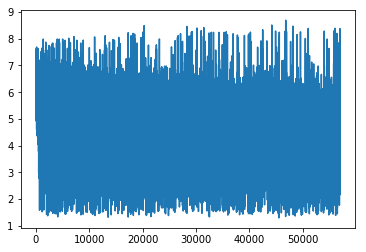

In [14]:
# train a logistic model

# weight and parameter initialization
W = np.random.randn(V, V) / np.sqrt(V)
losses = []
epochs = 1 # can have more epoches but 1 is sufficient to converge
lr = 1e-1 # learning rate

def softmax(a):
    a = a - a.max()
    exp_a = np.exp(a)
    return exp_a / exp_a.sum(axis=1, keepdims=True)

# what is the loss if we set W = log(bigram_probs)?
W_bigram = np.log(bigram_probs)
bigram_losses = []


t0 = datetime.now()
for epoch in range(epochs):
    # shuffle sentences at each epoch
    random.shuffle(sentences)

    j = 0 # keep track of iterations
    for sentence in sentences:
        # convert sentence into one-hot encoded inputs and targets
        sentence = [start_idx] + sentence + [end_idx]
        n = len(sentence)
        inputs = np.zeros((n - 1, V))
        targets = np.zeros((n - 1, V))
        inputs[np.arange(n - 1), sentence[:n-1]] = 1 # first to second last
        targets[np.arange(n - 1), sentence[1:]] = 1 # second to last

        # get output predictions
        predictions = softmax(inputs.dot(W))

        # do a gradient descent step
        W = W - lr * inputs.T.dot(predictions - targets)

        # keep track of the loss
        loss = -np.sum(targets * np.log(predictions)) / (n - 1)
        losses.append(loss)

        # keep track of the bigram loss
        # only do it for the first epoch to avoid redundancy
        if epoch == 0:
            bigram_predictions = softmax(inputs.dot(W_bigram))
            bigram_loss = -np.sum(targets * np.log(bigram_predictions)) / (n - 1)
            bigram_losses.append(bigram_loss)


        if j % 10 == 0:
            print("epoch:", epoch, "sentence: %s/%s" % (j, len(sentences)), "loss:", loss)
        j += 1

print("Elapsed time training:", datetime.now() - t0)
plt.plot(losses)

avg_bigram_loss: 3.7779453269292618


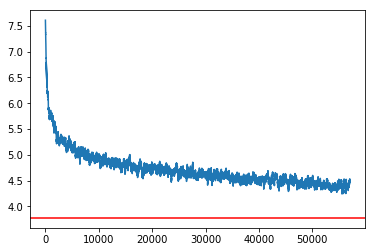

In [15]:
# plot a horizontal line for the bigram loss
avg_bigram_loss = np.mean(bigram_losses)
print("avg_bigram_loss:", avg_bigram_loss)
plt.axhline(y=avg_bigram_loss, color='r', linestyle='-')

# plot smoothed losses to reduce variability
def smoothed_loss(x, decay=0.99):
    y = np.zeros(len(x))
    last = 0
    for t in range(len(x)):
        z = decay * last + (1 - decay) * x[t]
        y[t] = z / (1 - decay ** (t + 1))
        last = z
    return y

plt.plot(smoothed_loss(losses))
plt.show()

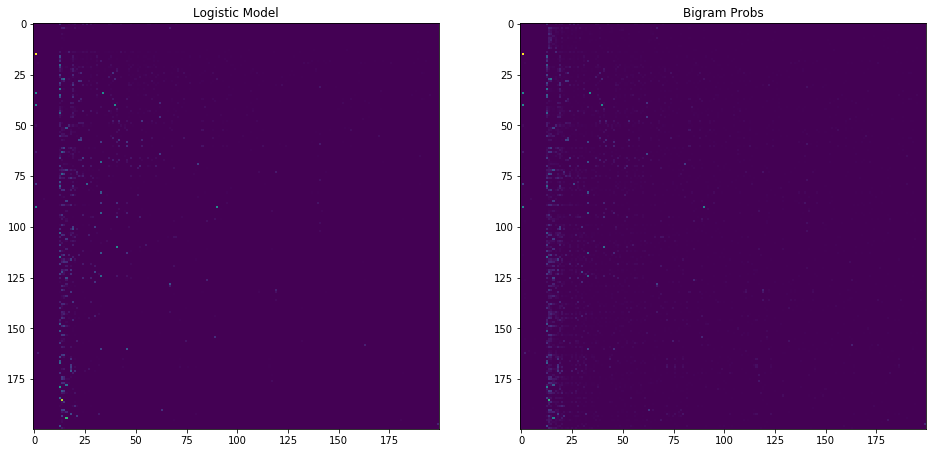

In [24]:
# plot W and bigram probs side-by-side
# for the most common 200 words
plt.figure(figsize=(16,16))
plt.subplot(1,2,1)
plt.title("Logistic Model")
plt.imshow(softmax(W)[:200,:200])
plt.subplot(1,2,2)
plt.title("Bigram Probs")
plt.imshow(bigram_probs[:200,:200])
plt.show()

In [25]:
# Two weights are equivalent!